In [1]:
import pandas
import numpy
import retl
import os
import pathlib
import glob
import matplotlib.pyplot as plt
import re
import scipy.stats
import helper

In [2]:
dir_experiment = '9WMNFC'
experiment_name = 'Correlation'

mypath = fr'{dir_experiment}\{experiment_name}_Results' 
if not os.path.isdir(mypath):
    os.makedirs(mypath)

In [3]:
### parse data ###

standard_plate = retl.parse(fr'{dir_experiment}/Cutinase_Standard.xml')    # Results standard
sample_plate = retl.parse(fr'{dir_experiment}/Cutinase_Sample.xml')        # Results samples
sample_names = pandas.read_excel(fr'{dir_experiment}/Wells.xlsx', sheet_name = 'MTP') # Excel list with sample names
conc = pandas.read_excel(fr'{dir_experiment}/Wells.xlsx', sheet_name = 'Cutinase_Standard') # Excel list with concentrations of standard curve

In [4]:
sample = sample_plate['Label1_Copy1'].value
standardraw = numpy.array(standard_plate['Label1_Copy1'].value)
time = (sample_plate['Label1_Copy1'].time)*60 #Time in minutes and not in hours

In [5]:
blankpositions=[51,52,53,60,61,62,69,70,71]
blank=numpy.mean([standardraw[0,i] for i in blankpositions])

standardmeans=[]
standardstds=[]
count=0
for i in range(21):
    item = standardraw[0,count:count+3]-blank
    if numpy.all(numpy.isnan(item) == False):
        standardmeans.append(numpy.mean(item).tolist())
        standardstds.append(numpy.std(item).tolist())
    count+=9
    if count==72:
        count=3
    elif count==75:
        count=6
blank

0.4356666666666667

# Calibration curve

In [6]:
## Linear regression ##

conc = conc.loc[0:len(standardmeans)-1]
calib_slope, calib_intercept, calib_r_value, calib_p_value, calib_std_err = scipy.stats.linregress(conc['Concentration'], standardmeans)
calib_r_value = round(calib_r_value,4)
calib_slope = round(calib_slope, 4)
calib_intercept = round(calib_intercept, 4)
#print(conc)

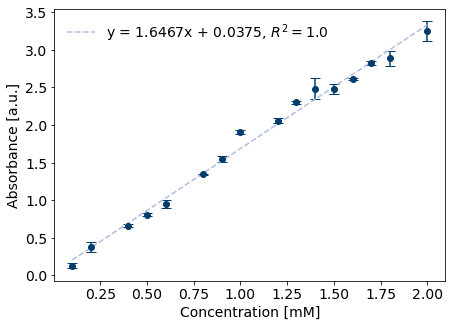

In [7]:
### Plot ###

calibrationplot = plt.figure(figsize=(7,5)) 

plt.errorbar(conc['Concentration'], standardmeans, yerr =standardstds, fmt = 'o',capsize = 5,  color = '#023D6B')
plt.xlabel('Concentration [mM]', fontsize = 14)
plt.ylabel('Absorbance [a.u.]', fontsize = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)
#plt.title('Calibration with 4NP', fontsize = 14)

plt.plot(conc['Concentration'], calib_intercept + calib_slope*conc['Concentration'], 'r', label=f'y = {calib_slope}x + {calib_intercept}, $R^2 = {round(calib_r_value,2)}$', color = '#ADBDE3', ls ='--')


plt.legend(frameon = False, fontsize = 14)
calibrationplot.savefig(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_Cutinase-Calibration', dpi=600, bbox_inches='tight')

# Data evaluation

In [8]:
def getIndices(value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    position = pandas.read_excel(fr'{dir_experiment}/Wells.xlsx', sheet_name = 'MTP',index_col=0)
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = position.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((str(row)+str(col)))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

C:\Users\muellerc\AppData\Local\Continuum\miniconda3\envs\dibecs_3.2.2\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


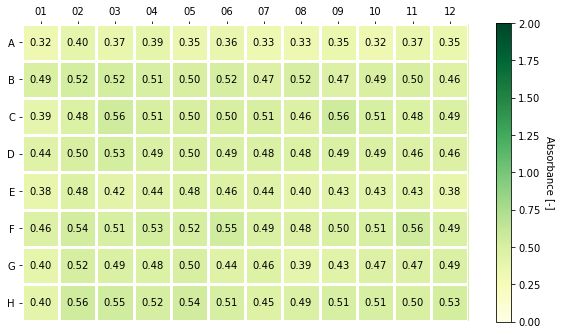

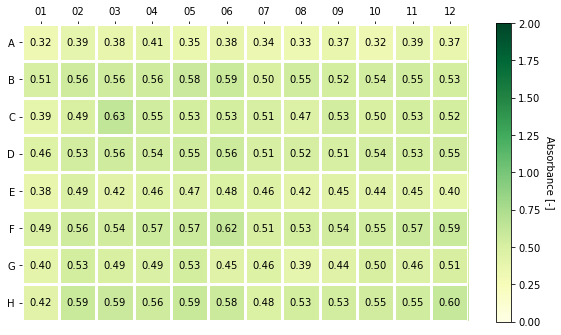

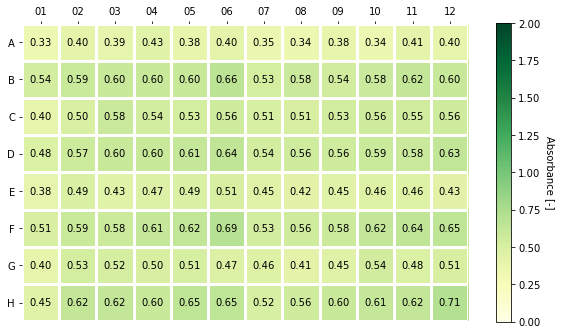

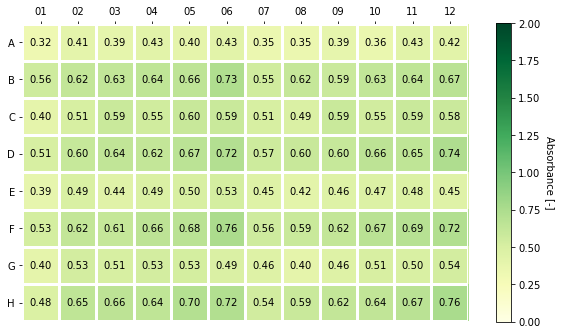

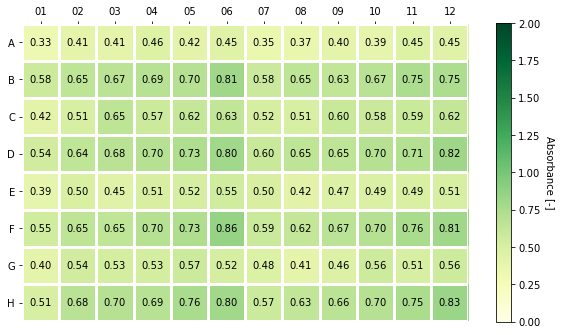

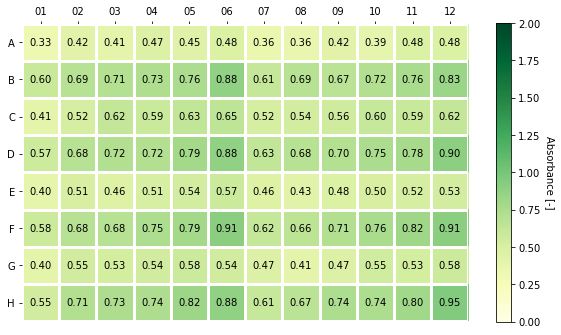

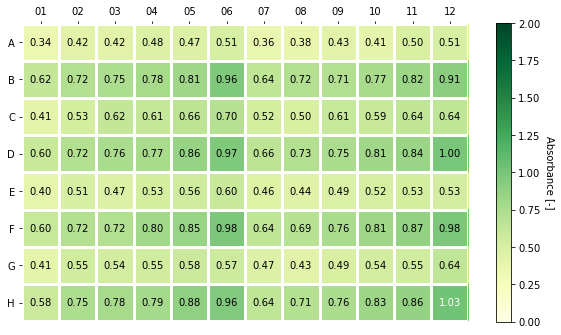

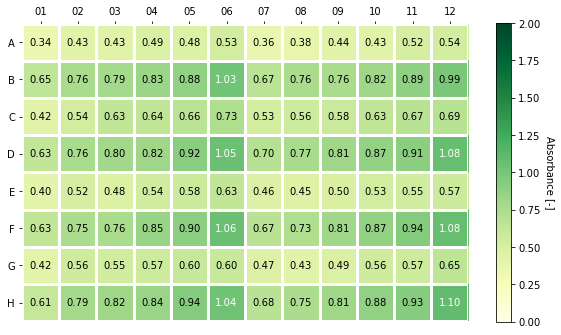

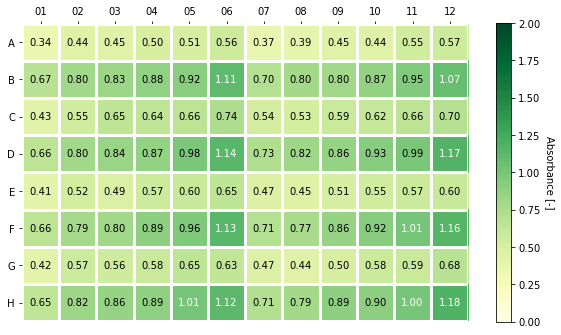

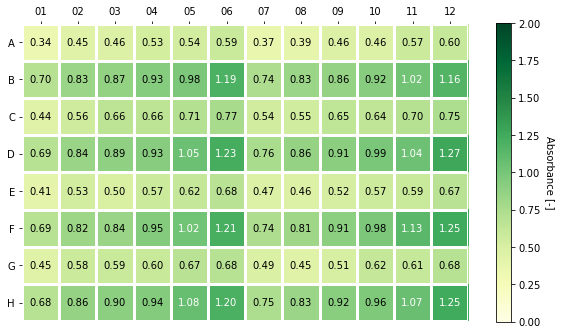

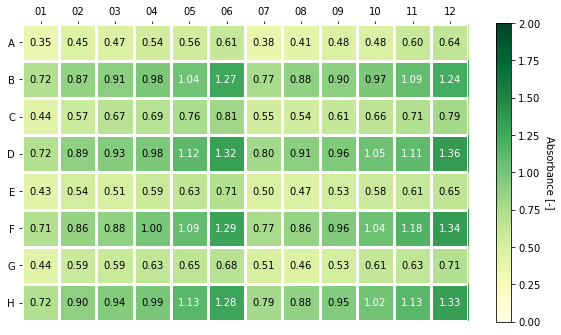

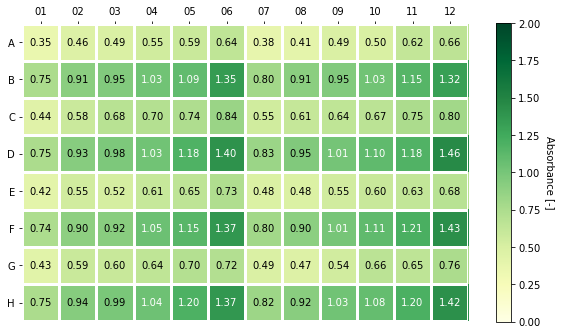

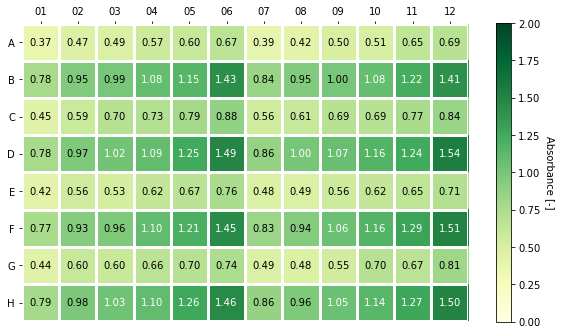

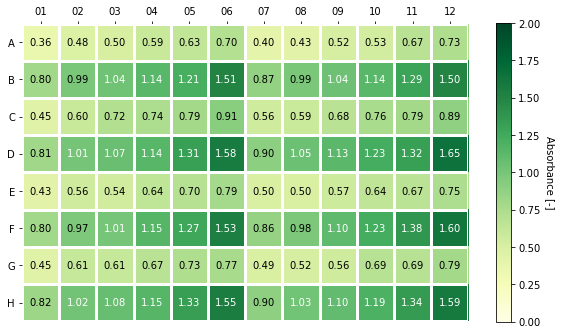

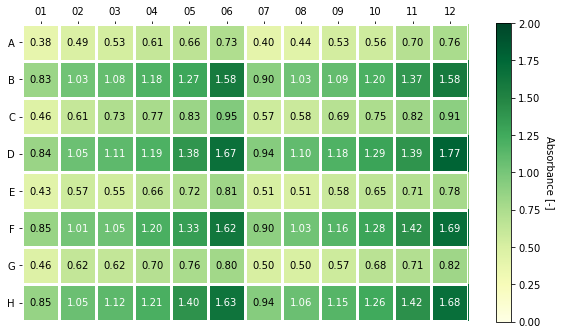

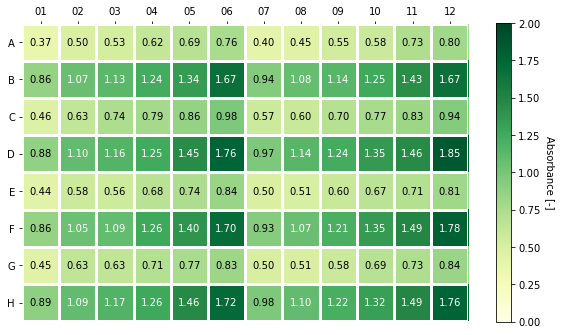

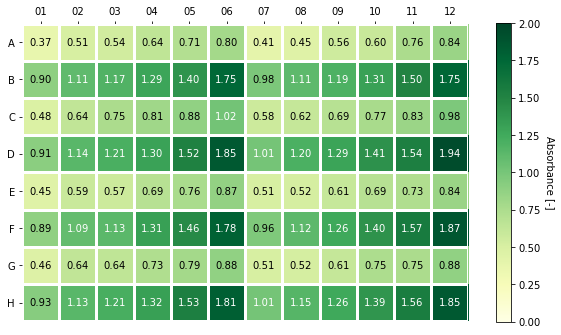

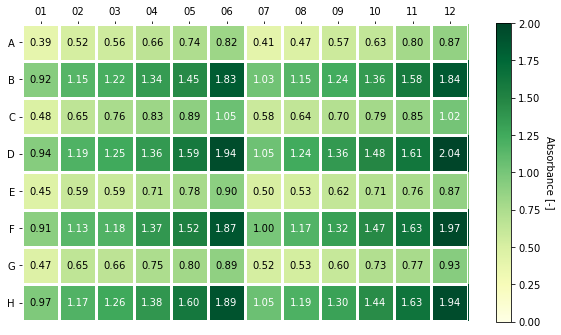

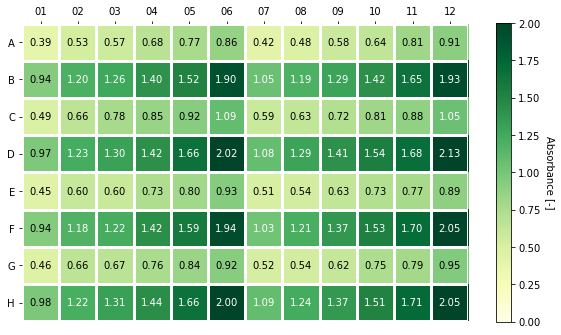

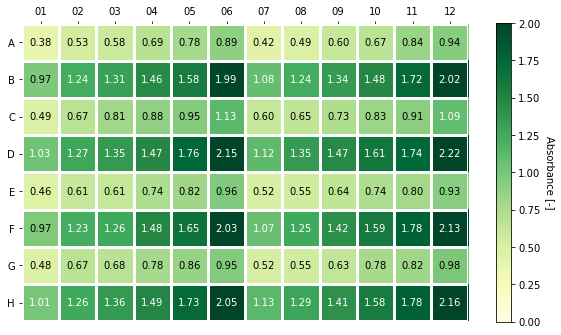

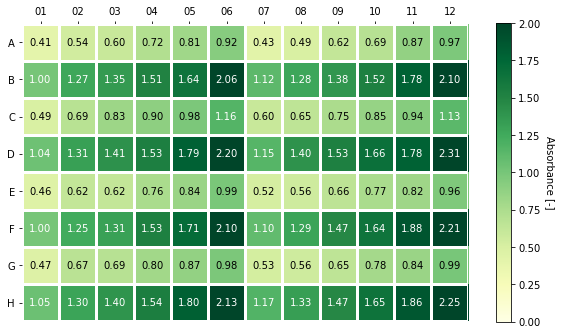

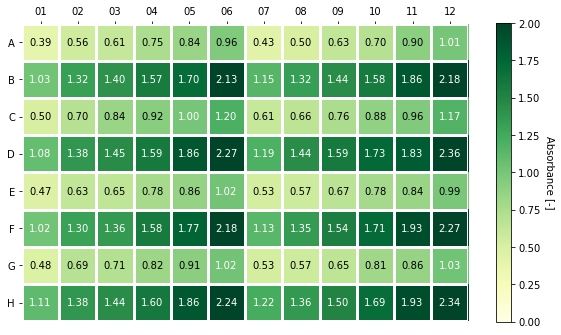

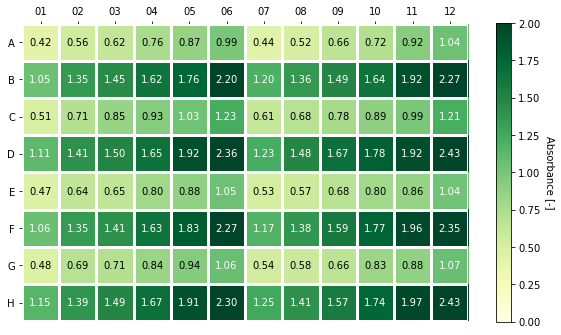

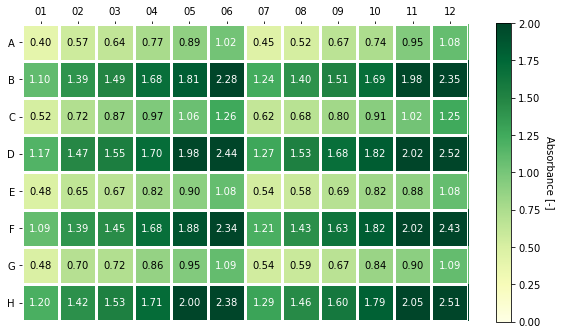

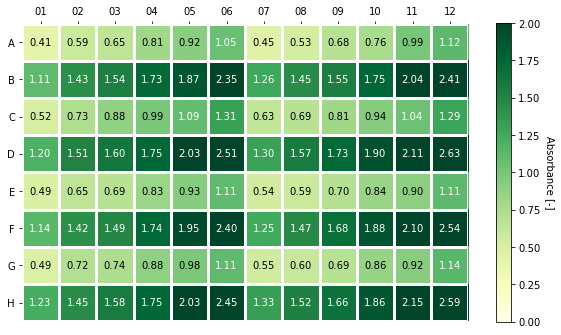

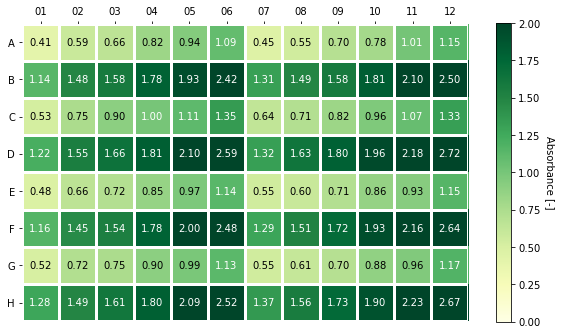

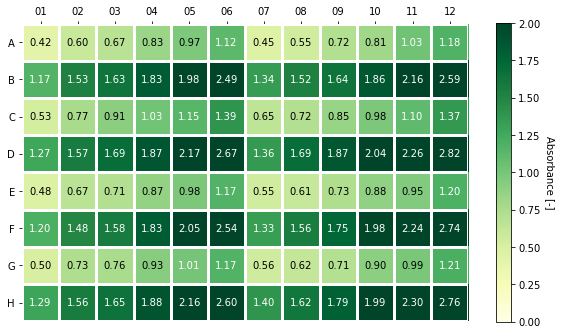

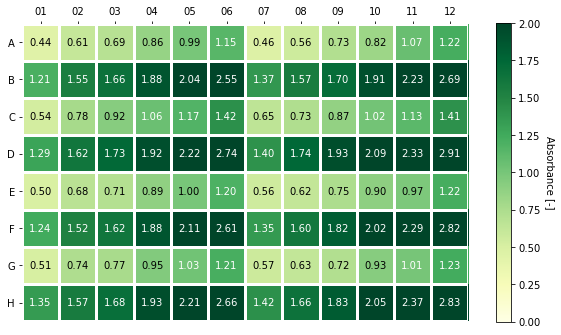

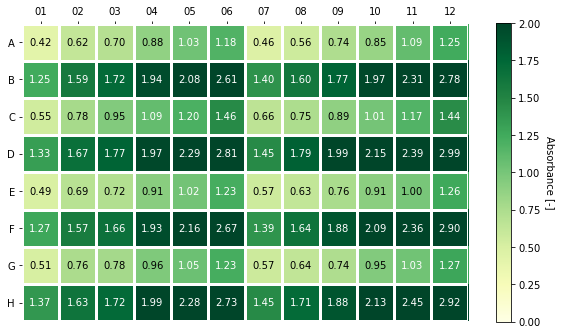

In [10]:
### heatmap for all measurements ###

mypath = fr'{dir_experiment}\{experiment_name}_Results_HeatmapCutinase' 
if not os.path.isdir(mypath):
    os.makedirs(mypath)

n = len(sample)

#wells = [f'{r}0{c}' for c in range(1, 12) for r in 'ABCDEFGH']

row = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
column = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for ai, i in enumerate(range(1,n)):
    fig, ax = plt.subplots(figsize = (10,10))
    heat = numpy.array(sample.loc[i])
    heat = heat.reshape(8,12)
    im, cbar = helper.heatmap(heat, row, column, ax = ax,  cmap = 'YlGn',cbarlabel = 'Absorbance [-]',
                            cbar_kw = dict(shrink = 0.55),  vmin = 0, vmax = 2)
    texts = helper.annotate_heatmap(im, threshold = 1, valfmt = '{x:.2f}') #add annotations as two digit numbers
    
    plt.savefig(fr'{dir_experiment}\{experiment_name}_Results_HeatmapCutinase\{experiment_name}_Heatmap_Time_{ai}.png'.format(ai=ai))

8
8
8
8
8
8
8
8
8
8
8
8


Text(0.5, 0, 'Signal peptide')

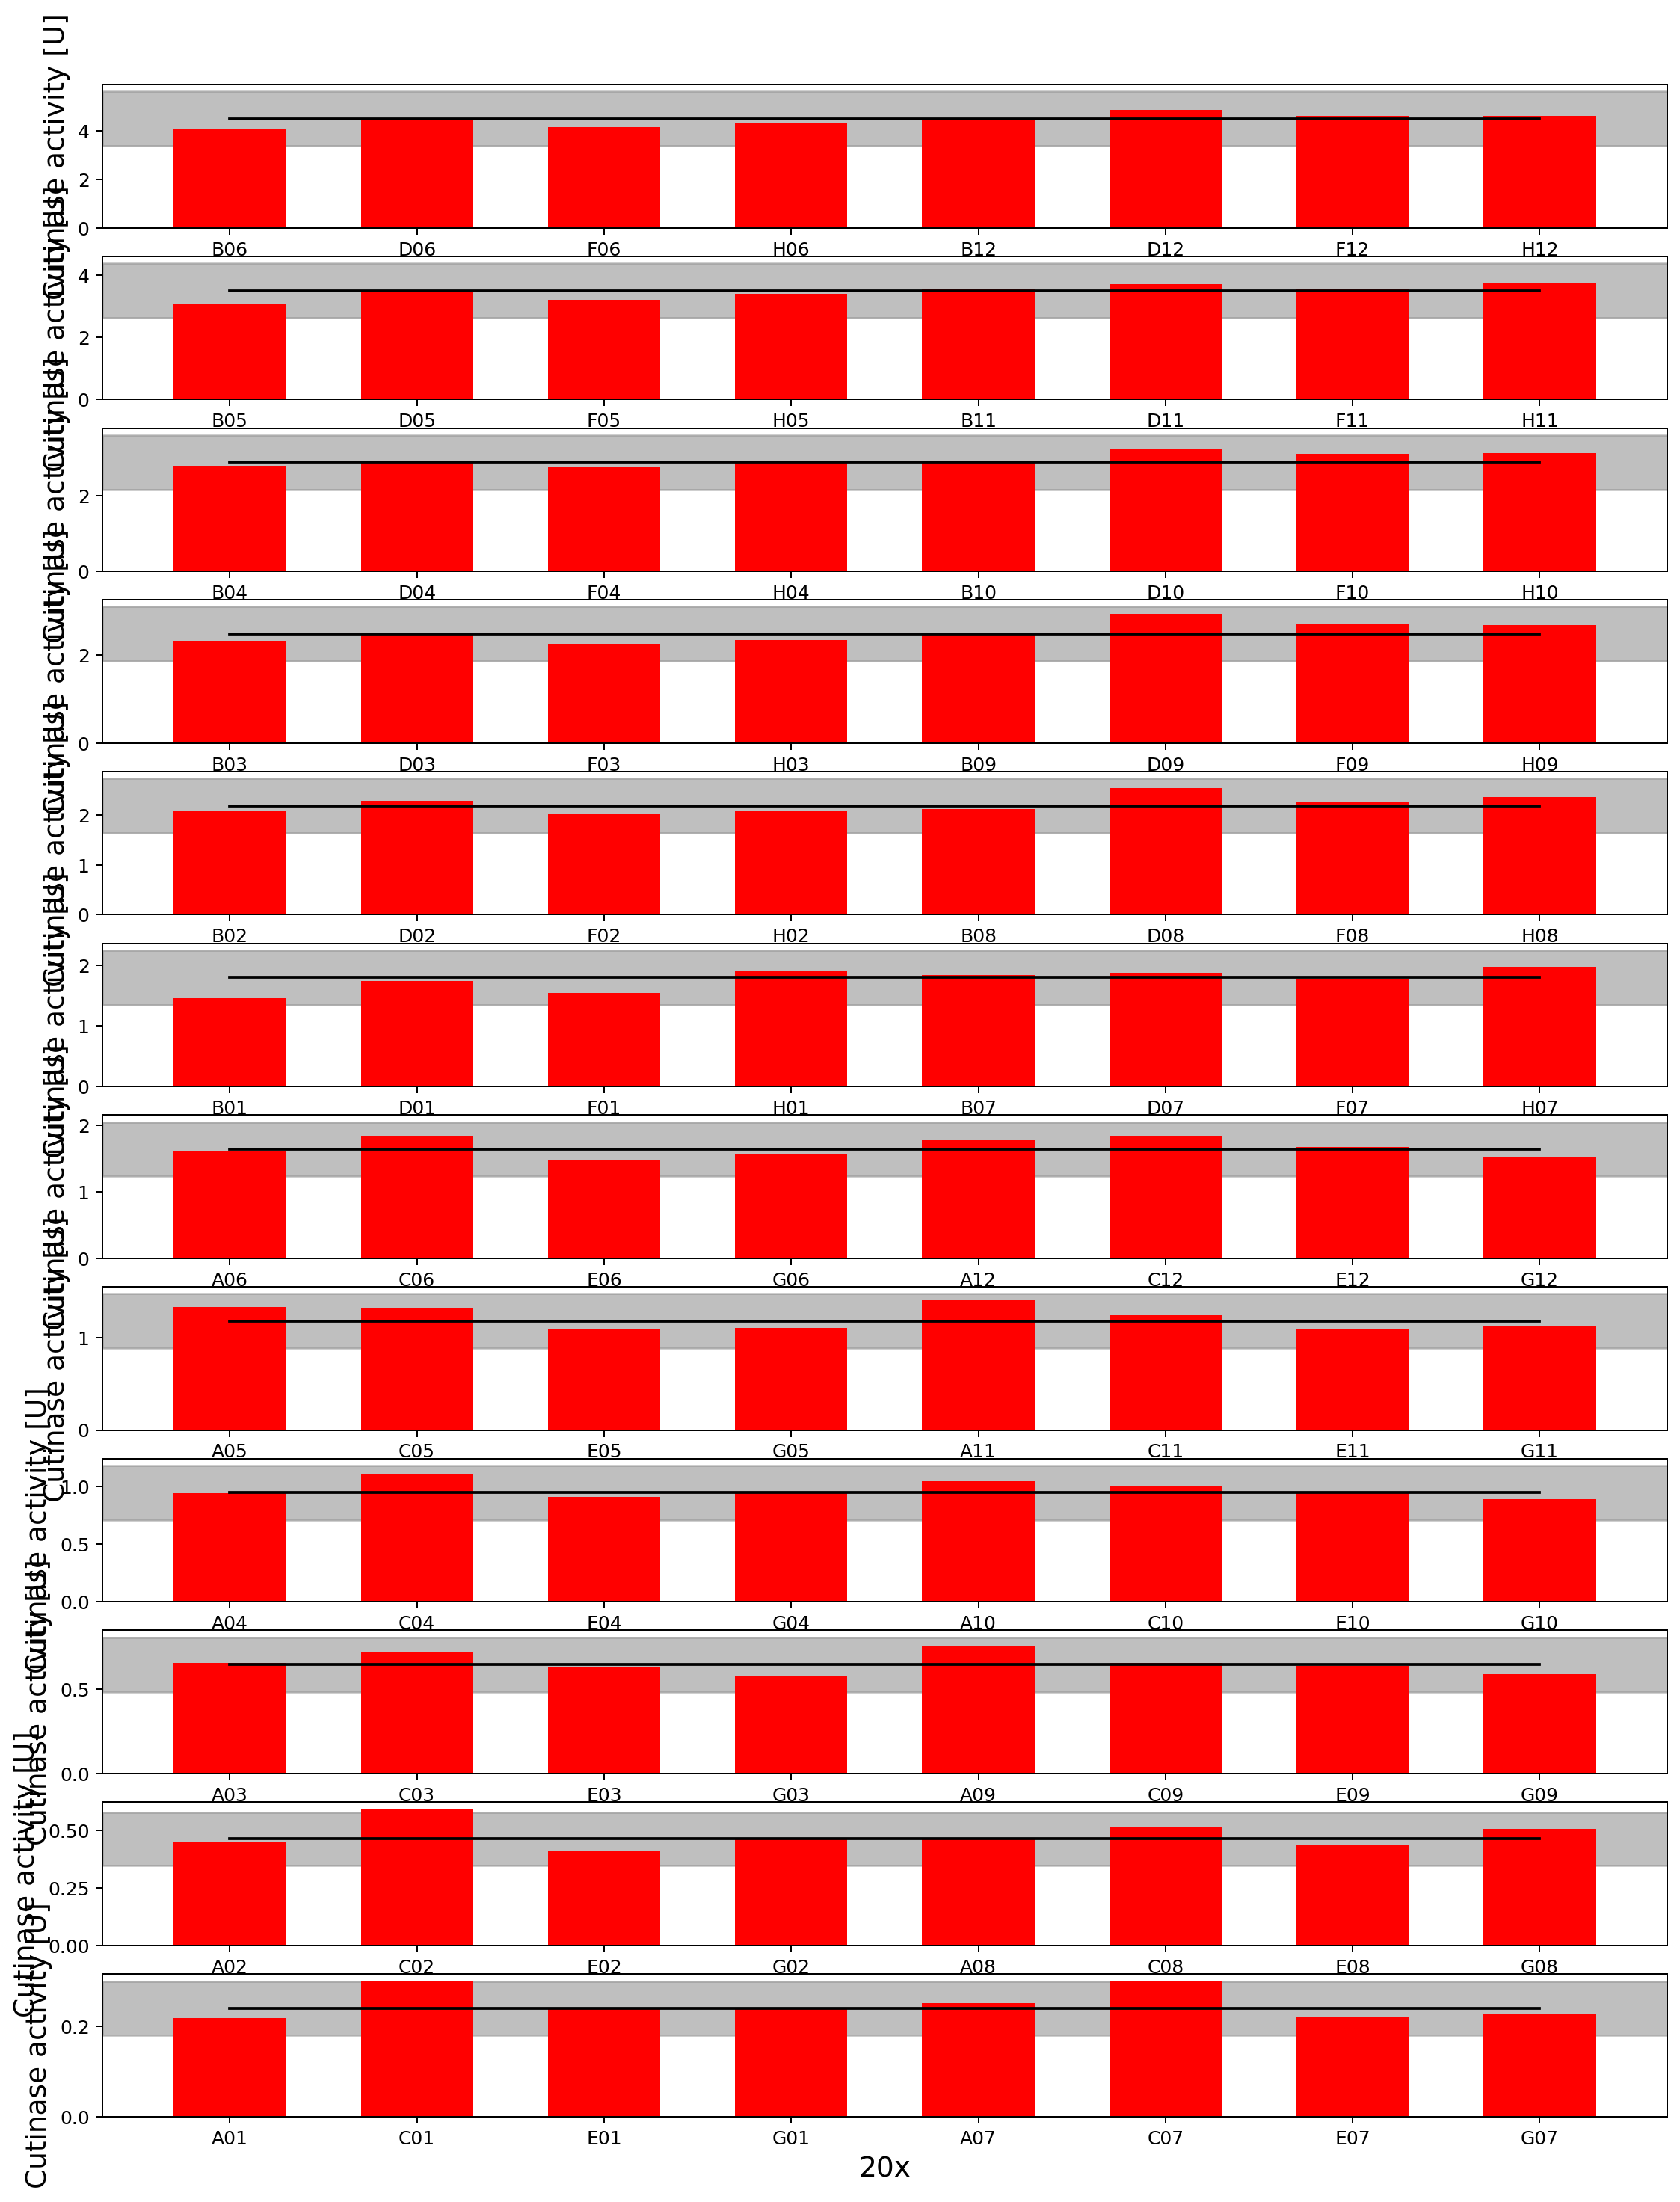

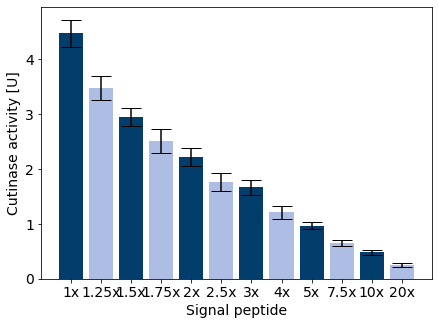

In [10]:
DF = 500
strain = ['1x', '1.25x', '1.5x', '1.75x', '2x', '2.5x', '3x', '4x', '5x', '7.5x', '10x', '20x']
fig, ax = plt.subplots(len(strain), figsize=(15,20), dpi=180)
strain_means = []
strain_stds = []
all_used_EAs = []

for i,s in enumerate(strain):
    wells = getIndices(s)
    #print(wells)
    slopes = []
    intercepts = []
    r_values = []
    EAs = []
    used_EAs = []

   
    for w in wells:
        slope_sample, intercept_sample, r_values_sample, p_value_s1, std_err_S1  = scipy.stats.linregress(time[w], sample[w])
        slopes.append(slope_sample)
        intercepts.append(intercept_sample)
        r_values.append(r_values_sample)
        EA = (slope_sample * DF) * (1/calib_slope) * 0.24 #Inverse slope, because A/cp, 0.04 converts mM to µmol
        EAs.append(EA)
        used_EAs.append(EA)        

        
# DO NOT USE THIS UNLESS YOU KNOW WHAT YOU ARE DOING
#         if r_values_sample > 0.99:
#             used_EAs.append(EA)
            
        
#        for k in used_EAs:
#            if k > 1.25*numpy.median(EAs) or k < 0.75*numpy.median(EAs):
#                used_EAs.remove(k)

# USE THIS ONLY IN CASE OF TECHNICAL PROBLEMS WITH SPECIFIC WELLS
#         for k in used_EAs:
#             if k < 0.1:
#                 used_EAs.remove(k)

    all_used_EAs.append(used_EAs)
    
    ax[i].set_ylabel('Cutinase activity [U]', fontsize = 15)
    ax[i].axhspan(numpy.median(EAs)*1.25, numpy.median(EAs)*0.75, color='gray', alpha=0.5)
    ax[i].set_xlabel('{}'.format(s), fontsize = 15)
    EAmedian=[numpy.median(EAs) for z in EAs]
    ax[i].plot(wells,EAmedian, color='black')
            
    strain_mean=numpy.mean(used_EAs)
    strain_std=numpy.std(used_EAs)
    strain_means.append(strain_mean)
    strain_stds.append(strain_std)
    
    #ax[i].set_xticks(wells)
    #ax[i].set_yticks(size = 20)
#     ax[i].set_ylim(bottom = 0, top = numpy.max(EAs)+ 0.2)
    ax[i].bar(wells, EAs, capsize =10, color = 'red', width = 0.6, linewidth = 0.7, align = 'center')
    print(len(used_EAs))
    
    slopes = pandas.DataFrame({'Well' : wells,
                           'Delta(A410)[a.u./min]' : slopes,
                           'Rsquared' : r_values },
                         columns=['Well','Delta(A410)[a.u./min]', 'Rsquared'])
#     print(slopes)
            
meanplot=plt.figure(figsize=(7,5))
plt.bar(strain, strain_means, yerr = strain_stds, capsize =10, color = ('#023D6B','#ADBDE3'))
plt.xticks(strain, size = 14) #rotation = 45
plt.yticks( size = 14)
#plt.ylim(bottom = 0, top = numpy.max(strain_means)+0.5)
plt.ylabel('Cutinase activity [U]', fontsize = 14)
plt.xlabel('Signal peptide', fontsize = 14)


In [11]:
fig.savefig(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_CutinaseActivity_wells', dpi=600, bbox_inches='tight')
meanplot.savefig(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_CutinaseActivity', dpi=600, bbox_inches='tight')

In [12]:
activity = pandas.DataFrame({'Strain' : strain,
                             'Cutinase activity [U]' : strain_means,
                             'Standard deviation' : strain_stds }, 
                             columns=['Strain','Cutinase activity [U]', 'Standard deviation'])
activity.to_excel(excel_writer = fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_result_cutinase.xlsx', sheet_name = 'cutinase')
activity

,Strain,Cutinase activity [U],Standard deviation
0,1x,4.474223,0.243524
1,1.25x,3.471454,0.218126
2,1.5x,2.950619,0.165384
3,1.75x,2.515899,0.217103
4,2x,2.224766,0.161616
5,2.5x,1.762656,0.168896
6,3x,1.664532,0.132169
7,4x,1.213028,0.119356
8,5x,0.970768,0.068399
9,7.5x,0.650110,0.057178


In [13]:
#t-test to compare differences between interesting strains 

strain1 = 'NprE'
strain2 = 'YncM'

a = scipy.stats.ttest_ind(all_used_EAs[strain.index(strain1)],all_used_EAs[strain.index(strain2)])
b = scipy.stats.ttest_ind(all_used_EAs[strain.index(strain1)],all_used_EAs[strain.index(strain2)], equal_var = False)

print(a)
#print(b)


ValueError: 'NprE' is not in list

In [ ]:
slopes = pandas.DataFrame({'Well' : wells,
                           'Delta(A410)[a.u./min]' : slope_sample,
                           'Rsquared' : r_values_sample },
                         columns=['Well','Delta(A410)[a.u./min]', 'Rsquared'])
slopes